In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim

In [4]:
def read_XYZformat(fln):
    
    solvent_indices    = {"O": 0,
                               "C" : 1,
                               "H": 2,
                               "N" : 3
                              }
    
    #Modified from https://github.com/pele-python/pele/blob/master/pele/utils/xyz.py
    fin = open(fln,'r')
    natoms = int(fin.readline())
    comment = fin.readline()[:-1]
    coords = np.zeros([natoms, 3], dtype="float64")
    atomtypes = []
    for x in coords:
        line = fin.readline().split()
        atomtypes.append(solvent_indices[str(line[0])])
        x[:] = list(map(float, line[1:4]))
    fin.close()
    return (np.asarray(coords), comment, np.asarray(atomtypes))

def generate_solvent_COMs(coords,metadata):
    
    #Definitions of numbers of atoms
    n_atoms_solute = metadata["n_atoms_solute"]; total_atoms = metadata["n_atoms"];
    n_atoms_solvent = len(metadata["solvent_indices"]);
    
    num_solvent = int((total_atoms-n_atoms_solute)/n_atoms_solvent)
    
    #Generating a new numpy array for the coordinates with reconstructed solvent
    reconstructed_solvent_POS = np.zeros_like(coords)
    reconstructed_solvent_POS[:n_atoms_solute,:] = coords[:n_atoms_solute,:]
    
    #Reconstruct solvent at boundaries and compute COMs
    solvent_COMs    = np.zeros((num_solvent,3))
    solvent_COM_dist = np.zeros((num_solvent,1)) 
    
    for solvent_mol in range(num_solvent):
        #Grab POS for all atoms in solvent molecule
        solvent_mol_coords = coords[n_atoms_solute+solvent_mol*n_atoms_solvent:
                                    n_atoms_solute+(solvent_mol+1)*n_atoms_solvent]
        
        bool_solvent_mol_coords = (np.abs(solvent_mol_coords - solvent_mol_coords[0,:]) > 0.5*metadata["box_length"])

        solvent_mol_coords = solvent_mol_coords+bool_solvent_mol_coords*np.sign(solvent_mol_coords[0,:])*metadata["box_length"]
        reconstructed_solvent_POS[n_atoms_solute+solvent_mol*n_atoms_solvent:
                                  n_atoms_solute+(solvent_mol+1)*n_atoms_solvent] = solvent_mol_coords

        solvent_COMs[solvent_mol]      = np.average(solvent_mol_coords,axis=0)
        solvent_COM_dist[solvent_mol]  = np.linalg.norm(np.average(solvent_mol_coords,axis=0))
        
    return reconstructed_solvent_POS, solvent_COMs, solvent_COM_dist

def reorient_molecule(newX,newY,newZ):
    #Confirm that new coordinate vectors are unit vectors
    newX = (1.0/np.linalg.norm(newX)*newX)
    newY = (1.0/np.linalg.norm(newY)*newY)
    newZ = (1.0/np.linalg.norm(newZ)*newZ)
    
    newZ_xy = np.linalg.norm(newZ[:2])
    
    precession_alpha  =  np.arctan2(newY[0]*newZ[1]-newY[1]*newZ[0],newX[0]*newZ[1]-newX[1]*newZ[0])
    nutation_beta     =  np.arctan2(newZ_xy,newZ[2])
    rotation_gamma    =  (-1.0)*np.arctan2((-1.0)*newZ[0],newZ[1])
    
    return precession_alpha, nutation_beta, rotation_gamma

def align_solute(coords,x_reference_atom,y_reference_atom):
    # Here, the x_reference_atom will be aligned to the x-axis. The y_reference_atom serves to define the
    # XY-plane, but as it is not guaranteed to be orthogonal to the new x-axis, the new_Y is the orthognal direction
    # which falls in this XY-plane. the new Z-axis is simply the cross-product of these two new vectors.
    #
    # Given the new set of axis, the Euler angles can be computed in order to construct a rotation matrix used to
    # transform all coordinates from the local coordinate system into the world coordinate system.
    
    #Define new X axis
    newX = x_reference_atom
    newX = (1.0/np.linalg.norm(newX))*newX
    #Use a second point to define the plane.
    #I.e. find a vector n orthogonal to a that is in the plane which contains a and b.
    refY = y_reference_atom
    newY = np.cross(newX,np.cross(newX,(1.0/np.linalg.norm(refY))*refY))
    newY = (1.0/np.linalg.norm(newY))*newY

    #Define new Z as perpendicular to plane defined by newX and newY
    newZ = np.cross(newX,newY)
    newZ = (1.0/np.linalg.norm(newZ)*newZ)

    #Apply reoriented molecules
    alpha,beta,gamma = reorient_molecule(newX,newY,newZ)

    #Define Rotation Matrix (Z1X2Z3, Euler Angles)

    RotMatrix = np.array([[np.cos(alpha)*np.cos(gamma)-np.cos(beta)*np.sin(alpha)*np.sin(gamma),-np.cos(alpha)*np.sin(gamma)-np.cos(beta)*np.cos(gamma)*np.sin(alpha),np.sin(alpha)*np.sin(beta)],
                          [np.cos(gamma)*np.sin(alpha)+np.cos(alpha)*np.cos(beta)*np.sin(gamma),np.cos(alpha)*np.cos(beta)*np.cos(gamma)-np.sin(alpha)*np.sin(gamma),-np.cos(alpha)*np.sin(beta)],
                          [np.sin(beta)*np.sin(gamma),np.cos(gamma)*np.sin(beta),np.cos(beta)]])

    POS_rotated = np.matmul(RotMatrix,np.transpose(coords)).transpose()
    
    return POS_rotated, RotMatrix


def center_solute(coords,com_selection):
    centered_coords = coords - com_selection.mean(axis=0)
    return centered_coords

def wrap_cell(coords,metadata,cellparam_np):
#def wrap_cell(coords,box_length):    
    #cellparam_np = np.array((box_length,box_length,box_length))
    
    wrapped_traj = coords + (metadata["box_length"]*(0.5) < np.abs(coords))*cellparam_np*(np.sign(cellparam_np*(0.5)-coords))

    return wrapped_traj
    

def load_traj(POS_fln):
    #Load Data
    POS, _, AtomNames = read_XYZformat(str(POS_fln))
    
    return POS, AtomNames

In [5]:
#Generating Training Data - Load XYZs from POS directory with corresponding VEE

metadata = {
    "topology_solute"       : [[4,5],[4,22],[22,15],[15,23],[15,16],[16,19],[16,18],
                               [18,21],[18,17],[17,20],[17,3],[3,22],[3,6],[6,7],
                               [6,1],[1,12],[12,14],[12,10],[10,13],[10,0],[0,11],
                               [0,8],[8,9],[8,2],[2,1],[2,4]],
    
    "n_atoms"               : 594,
    "n_atoms_solute"        : 24,
    "box_length"            : 20.55,
    
    "solvent_indices"       : {"CC": 0,
                               "C" : 1,
                               "H1": 2,
                               "H2": 3,
                               "H3": 4,
                               "N" : 5
                              }
        
}

translation_vectors = np.array([[metadata["box_length"],metadata["box_length"],metadata["box_length"]]])

num_atoms_solute=24
num_data=499
featurelist = []
train_outputs = []

question = 1.0

train_outputs_ref = np.loadtxt("test_VEE.dat",max_rows=num_data)

rand_upload_order = np.arange(num_data)
np.random.shuffle(rand_upload_order)

for i in rand_upload_order:
    temp_POS, temp_atomNames = load_traj("POS/POS_frame_"+str(i))
    #CENTER MOLECULE
    temp_cPOS = center_solute(temp_POS,temp_POS[:metadata["n_atoms_solute"]])
    #WRAP MOLECULES AT BORDERS
    temp_cwPOS = wrap_cell(temp_cPOS,metadata,translation_vectors)
    temp_cwPOS = center_solute(temp_cwPOS,temp_POS[:metadata["n_atoms_solute"]])
    #ALIGN MOLECULES
    temp_cwrPOS,metadata["RotationMatrix"] = align_solute(temp_cwPOS,0.5*(temp_cwPOS[16]+temp_cwPOS[18]),temp_cwPOS[7])
    for refl in [[1,1,1],[-1,1,1],[1,-1,1],[-1,-1,1]]:
    #for refl in [[1,1,1],[-1,1,1],[1,-1,1]]:
        atoms_and_names = np.append(refl*temp_cwrPOS,np.asarray([temp_atomNames]).transpose(),axis=1)
        combined = np.append(atoms_and_names.flatten(),question)
        featurelist.append( combined )
        train_outputs.append( train_outputs_ref[i] )

train_inputs = np.asarray(featurelist)
train_outputs = np.asarray(train_outputs)

np.save("training_data/inputs.npy", train_inputs)
np.save("training_data/outputs.npy", train_outputs)

#INCREASE THE NUMBER OF INPUTS BY SYMMETRY OPERATIONS

print(np.shape(train_inputs))

##REFLECTION
#train_C2_inputs = np.concatenate([1,1,1]*train_inputs
#                                 [-1,1,1]*train_inputs,
#                                 [1,-1,1]*train_inputs,
#                                 [-1,-1,1]*train_inputs)

#train_C2_outputs = np.concatenate(train_outputs*4)

#print(np.shape(train_inputs),np.shape(train_C2_inputs))
#print(np.shape(train_outputs),np.shape(train_C2_outputs))


FileNotFoundError: [Errno 2] No such file or directory: 'POS/POS_frame_367'

In [6]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Subset
from models import SciNet
from utils import target_loss 
from random import shuffle
device = torch.device("cuda:0")


In [82]:
scinet = SciNet(np.shape(train_inputs)[1]-1,1,25,2500)

inputs = torch.Tensor(train_inputs); outputs = torch.Tensor(train_outputs);
trainingdata = TensorDataset(inputs,outputs)

n_samples = len(trainingdata)
train_size = int(0.8*n_samples)

temp_ind=list(range(0,n_samples))

train_indices = temp_ind[0:train_size]
val_indices = temp_ind[train_size:]

train_dataset = Subset(trainingdata, train_indices)
val_dataset = Subset(trainingdata, val_indices)


train_dataloader = DataLoader(train_dataset, batch_size=1000,shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=1000,shuffle=True, num_workers=1)


# Training setup
SAVE_PATH = "trained_models/scinet1.dat"
N_EPOCHS = 85
optimizer = optim.Adam(scinet.parameters(),lr=0.00005)
loss_fn = nn.MSELoss(reduction='mean')
validation_losses = []
hist_error = []
val_hist_error = []
hist_loss = []
beta = 0.35


# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    val_epoch_error = []
    epoch_loss = []
    
    #Perform Training Step on Training Set
    for i_batch, minibatch in enumerate(train_dataloader):

        inputs, outputs = minibatch
        optimizer.zero_grad()
        pred = scinet.forward(inputs)
        
        #loss = target_loss(pred, outputs) + beta * scinet.kl_loss
        loss = loss_fn(pred[:,0],outputs)
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.data.detach().numpy())
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    
    #Perform on Validation Set
    with torch.no_grad():
            val_losses = []
            for i_batch, minibatch in enumerate(val_dataloader):
                inputs, outputs = minibatch
                scinet.eval()
                pred = scinet.forward(inputs)
                #yhat = scinet(inputs)
                val_loss = loss_fn(outputs, pred).item()
                #val_loss = target_loss(pred, outputs) + beta * scinet.kl_loss
                val_losses.append(val_loss)
                val_error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
                val_epoch_error.append(val_error)
                scinet.train()
            val_hist_error.append(np.mean(val_epoch_error))
            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {hist_loss[-1]:.3f}\t Validation loss: {validation_loss:.3f}")
    
    
    #print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))
    
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)
print(f"[{epoch+1}] Training RMSE: {hist_error[-1]:.3f}\t Validation RMSE: {val_hist_error[-1]:.3f}")


[1] Training loss: 0.203	 Validation loss: 0.248
[2] Training loss: 0.160	 Validation loss: 0.066
[3] Training loss: 0.104	 Validation loss: 0.050
[4] Training loss: 0.055	 Validation loss: 0.080
[5] Training loss: 0.069	 Validation loss: 0.036
[6] Training loss: 0.048	 Validation loss: 0.045
[7] Training loss: 0.046	 Validation loss: 0.049
[8] Training loss: 0.042	 Validation loss: 0.048
[9] Training loss: 0.035	 Validation loss: 0.037
[10] Training loss: 0.036	 Validation loss: 0.037
[11] Training loss: 0.030	 Validation loss: 0.048
[12] Training loss: 0.031	 Validation loss: 0.043
[13] Training loss: 0.029	 Validation loss: 0.040
[14] Training loss: 0.028	 Validation loss: 0.046
[15] Training loss: 0.026	 Validation loss: 0.047
[16] Training loss: 0.026	 Validation loss: 0.043
[17] Training loss: 0.024	 Validation loss: 0.041
[18] Training loss: 0.023	 Validation loss: 0.044
[19] Training loss: 0.021	 Validation loss: 0.044
[20] Training loss: 0.021	 Validation loss: 0.046
[21] Trai

In [83]:
print(f"[{epoch+1}] Training RMSE: {hist_error[-1]:.3f}\t Validation RMSE: {val_hist_error[-1]:.3f}")

[85] Training RMSE: 0.052	 Validation RMSE: 0.082


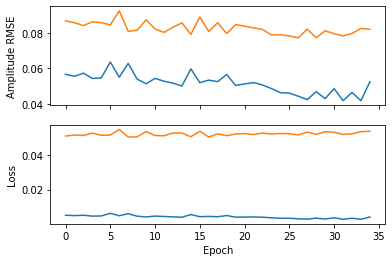

In [84]:
# Plot some training history data
%matplotlib inline 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(hist_error[50:])
ax1.plot(val_hist_error[50:])
ax1.set_ylabel("Amplitude RMSE")
ax2.plot(hist_loss[50:])
ax2.plot(validation_losses[50:])
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
plt.show()

In [28]:
# Load trained model
train_inputs = np.asarray(featurelist)
train_outputs = np.asarray(train_outputs)

scinet = SciNet(np.shape(train_inputs)[1]-1,1,25,2500)

scinet.load_state_dict(torch.load("trained_models/scinet1.dat"))

<All keys matched successfully>

In [29]:
npX_test = np.load("DATA/TEST/X_test.npy").astype(np.float32)
X_test = torch.stack([torch.from_numpy(np.array(i)) for i in npX_test])

yhat = np.zeros((len(X_test),1))

with torch.no_grad():
    for i in range(len(X_test)):
        yhat[i] = scinet(X_test[i,:])

#print(yhat)

(mu, sigma) = norm.fit(yhat)

n, bins, patches = plt.hist(yhat, 100, density = 1, facecolor='green', alpha=0.75)

#Predicted from NN (N=1000)
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#Predicted from Ab-Initio (N=500)
y2 = norm.pdf( bins, -0.24635, 0.19428)
l2 = plt.plot(bins, y2, 'b--', linewidth=2)

plt.grid(True)

plt.title(r'$\mathrm{Histogram\ of\ Vertical\ Gap\ AQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'DATA/TEST/X_test.npy'